# Segmentation of mammo tiles

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import PIL
#import pandas as pd
import colorcet as cc

cmap_grey = cc.cm.linear_grey_0_100_c0

In [3]:
def selectCases( cases, purpose, complexity, nb=1000 ): 
    dfAll = None
    for k,q in complexity.items():
        df  = cases[cases.purpose==purpose].query(q)
        df["classes"] = k
        idx   = np.unique(np.random.uniform( low=0, high=df.shape[0], size=10*nb).astype(int))
        idx   = idx[0:min(df.shape[0], nb, len(idx) )]
        dfAll = dfAll.append(df.iloc[idx]) if dfAll is not None else df.iloc[idx]
    return dfAll

In [4]:
path  = Path('../../data/DDSM-hm2dg_2')
d_im  = "tiles"
d_msk = "masks"

cases = pd.read_csv( path / "tiles.csv", sep=";", low_memory=False)
cases.drop("Unnamed: 0",axis=1,inplace=True)
display(cases.tail(2))

gp = cases.groupby( ["purpose", "simple_pathology"])["fnImage"].count()
print( gp )

,case_id,height,width,simple_pathology,patient_id,purpose,breast density,left or right breast,image view,abnormality id,...,pAir,pHealthy,pBenign,pMalignant,rCenter,cCenter,tile_size,obsAreas,fnImage,fnMask
161115,Mass-Training_P_02092_LEFT_MLO,4877,2755,MALIGNANT,P_02092,train,0.0,LEFT,MLO,1,...,0,34987,0,15189,0.74,0.32,50176,14847,train/Mass-Training_P_02092_LEFT_MLO_tile_1694...,train/Mass-Training_P_02092_LEFT_MLO_tile_1694...
161116,Mass-Training_P_02092_LEFT_MLO,4877,2755,MALIGNANT,P_02092,train,0.0,LEFT,MLO,1,...,0,35698,0,14478,0.74,0.27,50176,14847,train/Mass-Training_P_02092_LEFT_MLO_tile_1691...,train/Mass-Training_P_02092_LEFT_MLO_tile_1691...


purpose  simple_pathology          
test     BENIGN                        19648
         BENIGN;MALIGNANT                258
         MALIGNANT                     13623
train    BENIGN                        70904
         BENIGN;MALIGNANT                251
         BENIGN;MALIGNANT;MALIGNANT      177
         MALIGNANT                     55902
         MALIGNANT;BENIGN                354
Name: fnImage, dtype: int64


In [5]:
complexity={
#            "pHealthy":"pAir==0 and pBenign==0 and pMalignant==0",
            "pMalignant":"pMalignant > 0.1*tile_size and pMalignant > 0.62*obsAreas and pBenign==0 and pAir==0",
#            "pAir":"pAir>0.2 and pAir<1.0", 
            "pBenign":"pBenign/tile_size>0.4 and pMalignant==0 and pAir==0"
#            "pMalignant":"pMalignant > 0.99*obsAreas and pBenign==0 and pAir==0"
}
nb=1000
test  = selectCases( cases, "test",     complexity=complexity, nb=nb//2 )
train = selectCases( cases, "train", complexity=complexity, nb=nb )
cases = train.append( test, ignore_index=False )
cases.reset_index(drop=True,inplace=True)

print(f"Total: {cases.shape[0]}")
gp = cases.groupby( ["purpose", "classes"])["fnImage"].count()
print( gp )

#generate training and validation csv for fastai
dfData = cases.loc[: , ["purpose", "classes", "fnImage", "fnMask" ]]
dfData.to_csv( path / "tvData.csv", index=False)
dfData.head(2)
cases=None

Total: 3000
purpose  classes   
test     pBenign        500
         pMalignant     500
train    pBenign       1000
         pMalignant    1000
Name: fnImage, dtype: int64


In [6]:
#function to open 16bit as rgb withut loosing precision
def open_image_16bit2rgb( fn ): 
    a = np.asarray(PIL.Image.open( fn ))
    a = np.expand_dims(a,axis=2)
    a = np.repeat(a, 3, axis=2)
    return Image( pil2tensor(a, np.float32 ).div(65535) )
def open_mask_special( fn ): 
    a = PIL.Image.open( fn )
    a = (np.asarray(a)/127).astype(np.int)
    return ImageSegment( pil2tensor(a, np.float32 ))

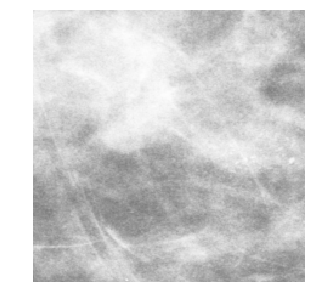

In [7]:
fnImage = path/d_im/dfData.fnImage.iloc[-1]
im=open_image_16bit2rgb(fnImage)
show_image( im, figsize=(5,5) )

1

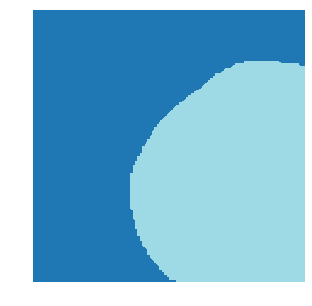

In [8]:
fnMask = path/d_msk/dfData.fnImage.iloc[-1]
mask   = open_mask_special(fnMask)
mask.show(figsize=(5,5), alpha=1)
np.max(mask.data.numpy())

In [9]:
print(mask.shape,mask.data)
print(mask.shape,mask.data.max())

torch.Size([1, 224, 224]) tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]])
torch.Size([1, 224, 224]) tensor(1)


In [10]:
codes =["healthy", "malignant", "benign"] 

In [11]:
fnImages = join_paths(dfData.fnImage.values, path/d_im)
fnMasks  = join_paths(dfData.fnMask.values, path/d_msk)
ixTrain  = dfData.purpose=="train"
ixValid  = ixTrain == False
dsTrain  = SegmentationDataset(join_paths(dfData.fnImage[ixTrain].values, path/d_im), 
                               join_paths(dfData.fnImage[ixTrain].values, path/d_msk), 
                               codes)
dsValid  = SegmentationDataset(join_paths(dfData.fnImage[ixValid].values, path/d_im), 
                               join_paths(dfData.fnImage[ixValid].values, path/d_msk), 
                               codes)
dsTrain.image_opener = dsValid.image_opener = open_image_16bit2rgb
dsTrain.mask_opener  = dsValid.mask_opener  = open_mask_special


In [12]:
tfms       = get_transforms()
dsTrainTfm = DatasetTfm(dsTrain, tfms[0], tfm_y=True)
dsValidTfm = DatasetTfm(dsValid, tfms[1], tfm_y=True)


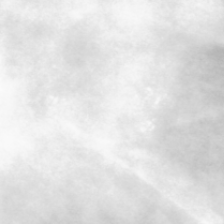

In [13]:
dsTrainTfm[0][0]

In [14]:
data = ImageDataBunch.create(dsTrainTfm, 
                             dsValidTfm, 
                             bs=64, 
                             size=224
                            )
data.normalize(imagenet_stats)

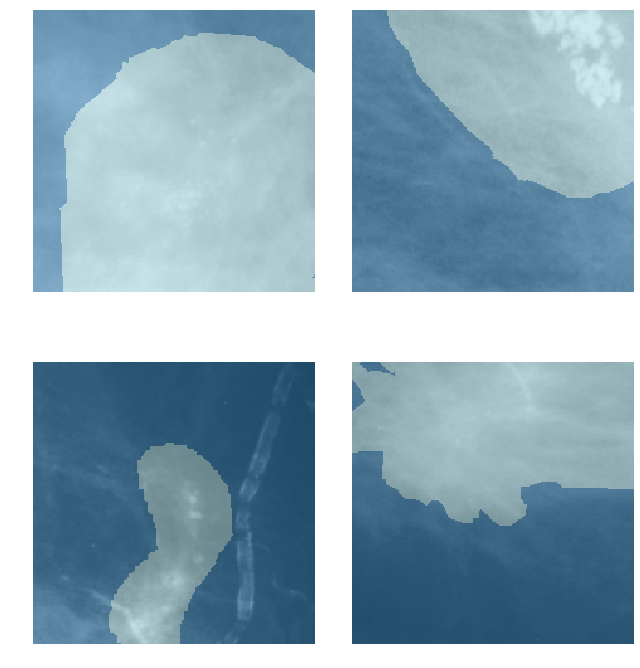

In [15]:
data.show_batch(2)

In [16]:
print(data.classes)
len(data.classes),data.c

['healthy', 'malignant', 'benign']


(3, 3)

In [17]:
void_code = 0

def acc_camvid(input, target):
    target = target.squeeze()
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
#learn = create_cnn( data, models.resnet34, metrics=error_rate )
learn = Learner.create_unet(data, models.resnet34, metrics=acc_camvid)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


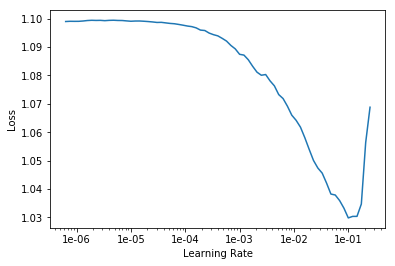

In [19]:
lr_find(learn)
learn.recorder.plot()

In [20]:
lr_last_layer=0.01
learn.fit_one_cycle(100, max_lr=lr_last_layer)

Total time: 20:52
epoch  train_loss  valid_loss  acc_camvid
1      1.021495    1.643776    0.368703    (00:16)
2      0.972379    1.866978    0.297155    (00:13)
3      0.915069    1.234816    0.137042    (00:12)
4      0.869225    1.098227    0.215350    (00:12)
5      0.831063    1.309028    0.266643    (00:12)
6      0.802712    1.077549    0.236505    (00:12)
7      0.778772    1.506813    0.297717    (00:12)
8      0.752626    1.378561    0.230222    (00:12)
9      0.739354    0.976160    0.386737    (00:12)
10     0.717705    1.313865    0.263563    (00:12)
11     0.685936    1.065125    0.297269    (00:12)
12     0.652244    1.126976    0.331068    (00:12)
13     0.631823    1.534258    0.389905    (00:12)
14     0.588238    1.419968    0.376009    (00:12)
15     0.563100    1.386699    0.292191    (00:12)
16     0.546845    1.154756    0.292260    (00:12)
17     0.536009    1.149705    0.413997    (00:12)
18     0.521558    1.086729    0.262106    (00:12)
19     0.504784    1.3

In [21]:
learn.save('mammo-resnet34-p-stage-1')

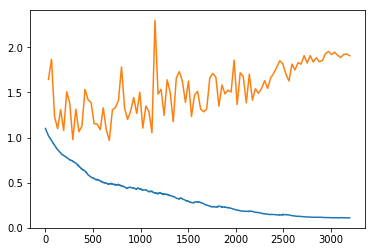

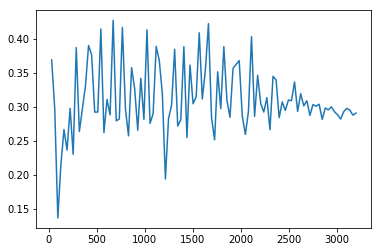

In [22]:
learn.recorder.plot_losses(), plt.show()
learn.recorder.plot_metrics()

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

In [ ]:
learn.load('mammo-resnet34-p-stage-1')

In [ ]:
print("pretrain learning rate: ", lr_last_layer)
learn.lr_find(start_lr=1e-8*lr_last_layer, end_lr=50*lr_last_layer, num_it=200)
learn.recorder.plot(skip_start=1, skip_end=2)

In [ ]:
max_lr = lr_last_layer*0.75
min_lr = max_lr*1e-4
print(f"unfreeze learning slice: {min_lr:.2e} to {max_lr:.2e} ")

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10,  max_lr=slice(min_lr,max_lr))

In [ ]:
learn.recorder.plot_losses(), plt.show()
learn.recorder.plot_metrics()